# Data assembling and learning module

In [6]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import ntpath
import random
from imgaug import augmenters as iaa

plt.style.use('fivethirtyeight')

In [7]:
"""
Purpose: To Learn driving patterns from artificial data
Data created manually via unity-based drive simulator (laps: 3-r + 3-l) 
(sim app: github.com/udacity/self-driving-car-sim)

Fields:

center: image from center camera
left: image from left camera
right: image from right camera
steering: steering car angle ranged from -1 to 1
throttle: ranged from 0 to 1
reverse: ranged from 0 to 1
speed: speed measure ranged from 0 to ~30.4
"""

data_dir = './data'
data_path = data_dir + '/driving_log.csv'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
seed = random.seed(42)
data = pd.read_csv(data_path, names=columns)

In [8]:
pd.set_option('display.max_colwidth', None)

In [9]:
def path_leaf(path):
    
    """path splitter"""
    
    head, tail = ntpath.split(path)
    return tail

In [10]:
data['center'] = data['center'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)

In [11]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_08_14_04_41_15_419.jpg,left_2020_08_14_04_41_15_419.jpg,right_2020_08_14_04_41_15_419.jpg,0.0,0.000000,0.0,12.81134
1,center_2020_08_14_04_41_15_493.jpg,left_2020_08_14_04_41_15_493.jpg,right_2020_08_14_04_41_15_493.jpg,0.0,0.000000,0.0,12.78660
2,center_2020_08_14_04_41_15_578.jpg,left_2020_08_14_04_41_15_578.jpg,right_2020_08_14_04_41_15_578.jpg,0.0,0.000000,0.0,12.60275
3,center_2020_08_14_04_41_15_653.jpg,left_2020_08_14_04_41_15_653.jpg,right_2020_08_14_04_41_15_653.jpg,0.0,0.000000,0.0,12.57651
4,center_2020_08_14_04_41_15_735.jpg,left_2020_08_14_04_41_15_735.jpg,right_2020_08_14_04_41_15_735.jpg,0.0,0.243653,0.0,12.60955


In [12]:
data.describe()

,steering,throttle,reverse,speed
count,6650.000000,6650.000000,6650.000000,6650.000000
mean,0.002398,0.979746,0.005053,29.740818
std,0.156243,0.137017,0.063587,3.064007
min,-1.000000,0.000000,0.000000,0.000092
25%,0.000000,1.000000,0.000000,30.187373
50%,0.000000,1.000000,0.000000,30.190150
75%,0.000000,1.000000,0.000000,30.190300
max,1.000000,1.000000,1.000000,30.403800


In [13]:
num_bins = 25
max_samples_per_bin = 350
hist, bins = np.histogram(data['steering'], num_bins)
# centered with 0 bins
center = (bins[:-1] + bins[1:]) * 0.5

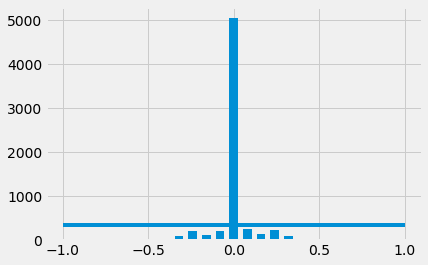

In [14]:
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (max_samples_per_bin, max_samples_per_bin));

## Data Balancing

In [15]:
"""Make data uniform-like, reduce bias """

print(f'Total data: {len(data)}')
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[max_samples_per_bin:]
    remove_list.extend(list_)

print(f'Removed {len(remove_list)}')
data.drop(data.index[remove_list], inplace=True)
print(f'Remaining {len(data)}')

Total data: 6650
Removed 4700
Remaining 1950


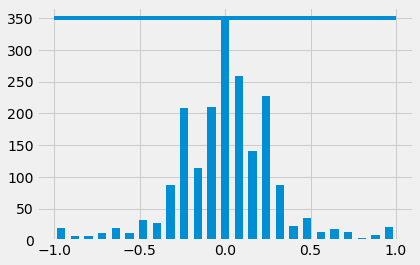

In [16]:
# Show balanced data

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (max_samples_per_bin, max_samples_per_bin));

## Data preparation

In [17]:
data.iloc[0]

center      center_2020_08_14_04_41_15_493.jpg
left          left_2020_08_14_04_41_15_493.jpg
right        right_2020_08_14_04_41_15_493.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                                  12.7866
Name: 1, dtype: object

In [18]:

def load_img_steering(datadir, df):
    
    """
    Returns camera images with corresponding steering angle
    
    datadir: images folder
    df: pd.DataFrame dataset
    """
    
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(indexed_data[3])
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

In [19]:
image_paths, steerings = load_img_steering(data_dir + '/IMG', data)

Splitting

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=seed)

In [21]:
print(f"Train split {len(X_train)}\nValid split {len(X_valid)}")

Train split 1560
Valid split 390


Text(0.5, 1.0, 'Validation set')

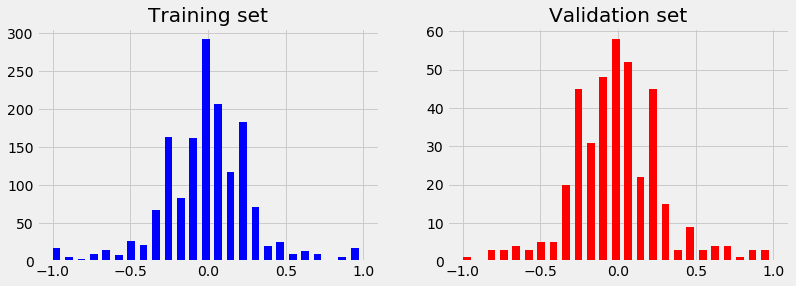

In [22]:
# Check data distribution

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
ax[0].set_title('Training set')
ax[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
ax[1].set_title('Validation set')


## Processing

In [25]:
"""Augment block"""

def zoom(image, scale=(1, 1.3)):
    zoom = iaa.Affine(scale=scale)
    image = zoom.augment_image(image)
    return image


def pan(image, pval=(-0.1, 0.1)):
    pan = iaa.Affine(translate_percent= {"x" : pval, "y": pval})
    image = pan.augment_image(image)
    return image


def img_random_brightness(image, threshold=(0.2, 1.2)):
    brightness = iaa.Multiply(threshold)
    image = brightness.augment_image(image)
    return image


def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


def random_augment(image, steering_angle, rand_rate=0.5):
    image = mpimg.imread(image)
    if np.random.rand() < rand_rate:
        image = pan(image)
    if np.random.rand() < rand_rate:
        image = zoom(image)
    if np.random.rand() < rand_rate:
        image = img_random_brightness(image)
    if np.random.rand() < rand_rate:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

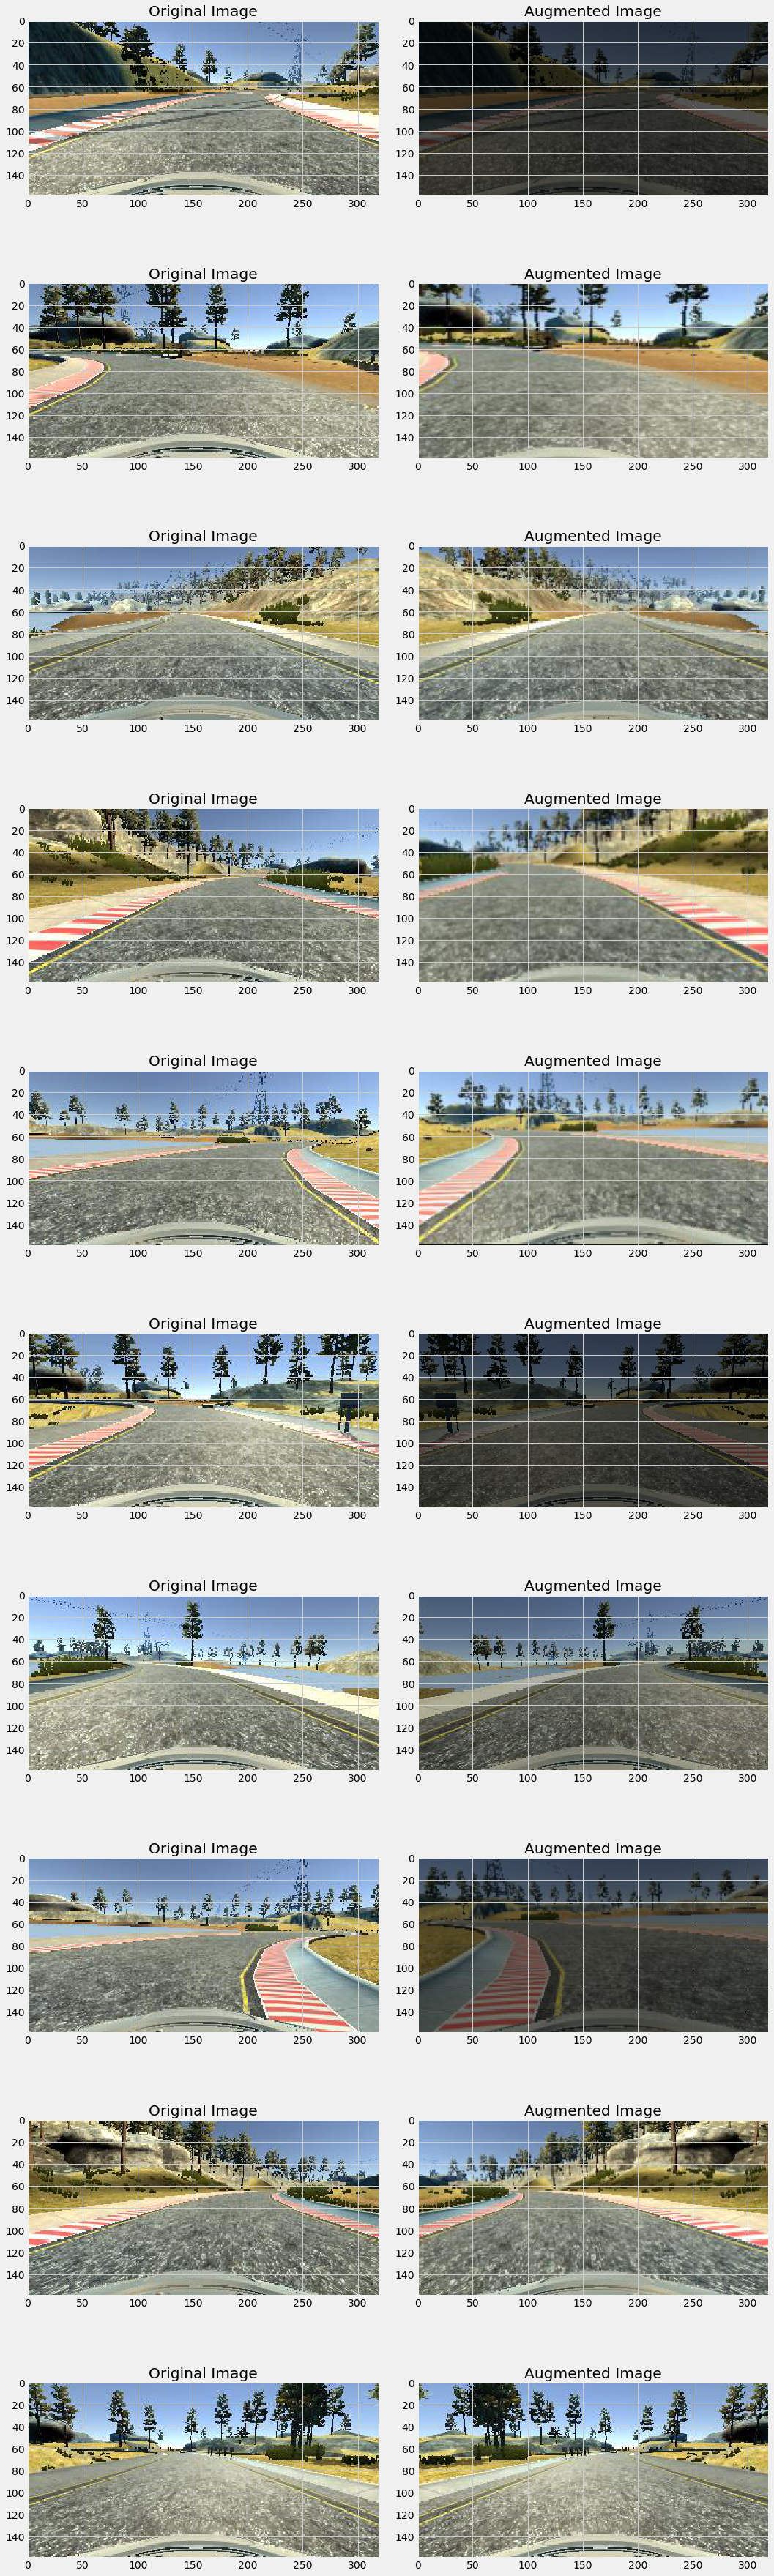

In [24]:
ncol = 2
nrow = 10

# Display comparison for 10 random images

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    rand = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[rand]
    random_steering = steerings[rand]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [37]:
def img_preprocess(img):
    
#     img = mpimg.imread(img)  # initial shape (160, 320, 3) 
    img = img[50:135,:,:]  # crop to remove noises - final shape (85, 320, 3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [42]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        
        yield (np.asarray(batch_img), np.asarray(batch_steering))
            
    

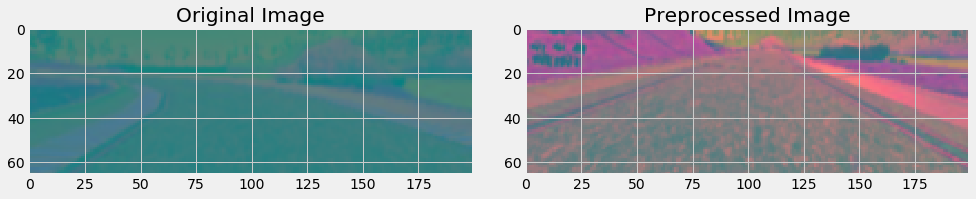

In [44]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, ax = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout()

ax[0].imshow(x_train_gen[0])
ax[0].set_title("Original Image")

ax[1].imshow(x_valid_gen[0])
ax[1].set_title("Preprocessed Image")

plt.show()

## Train model

In [48]:
#################
# Model params
#################

r_img_shape = X_train.shape[1:]  # (66, 200, 3)
epochs = 10
batch_size = 100

In [49]:
r_img_shape

()

In [60]:
def create_model():
     
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(24, (5, 5), padding='same', activation='relu', input_shape=(66, 200, 3)),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(36, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(48, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
        
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(50, activation='elu'),
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(1)
    ])
       
    optimizer = tf.optimizers.Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    return model
    

In [61]:
model = create_model()

In [62]:
history = model.fit(batch_generator(X_train, y_train, batch_size, 1),
                    steps_per_epoch=300,
                    epochs=epochs,
                    validation_data=batch_generator(X_valid, y_valid, batch_size, 0),
                    validation_steps=200,
                    verbose=1,
                    shuffle=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 300 steps, validate for 200 steps
Epoch 1/10
300/300 [==============================] - 159s 531ms/step - loss: 0.0646 - val_loss: 0.0374
Epoch 2/10
300/300 [==============================] - 168s 561ms/step - loss: 0.0446 - val_loss: 0.0398
Epoch 3/10
300/300 [==============================] - 163s 543ms/step - loss: 0.0423 - val_loss: 0.0361
Epoch 4/10
300/300 [==============================] - 166s 552ms/step - loss: 0.0394 - val_loss: 0.0348
Epoch 5/10
300/300 [==============================] - 164s 547ms/step - loss: 0.0384 - val_loss: 0.0340
Epoch 6/10
300/300 [==============================] - 152s 506ms/step - loss: 0.0363 - val_loss: 0.0387
Epoch 7/10
300/300 [==============================] - 148s 495ms/step - loss: 0.0351 - val_loss: 0.0369
Epoch 8/10
300/300 [==============================] - 157s 523ms/step - loss: 0.0347 - val_loss: 0.0367
Epoch 9/10
300/300 [==============================] - 127s 424ms/step - lo

0.029208600998688966


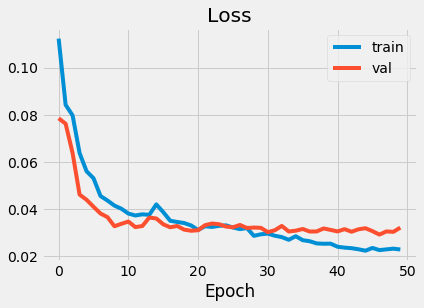

In [28]:
print("minimal loss:", min(history.history['val_loss']))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [29]:
model.save('fin_model.h5')